# Seldon and TensorFlow Serving MNIST Example

This example shows how you can combine Seldon with Tensorflo Serving. We will use a Seldon Tensorflow Serving proxy model image that will forward Seldon internal microservice prediction calls out to a Tensorflow serving server.

The example will use the MNIST digit classification task with the example MNIST model.


# Setup

In [ ]:
!pip install seldon-core

In [30]:
%matplotlib inline
import requests
from random import randint,random
import json
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import sys
sys.path.append("../../../notebooks")
from visualizer import get_graph
from seldon_core.proto import prediction_pb2
from seldon_core.proto import prediction_pb2_grpc
import grpc
import tensorflow as tf
from tensorflow.core.framework.tensor_pb2 import TensorProto

In [33]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def rest_predict_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/predict",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_input_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-input",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_output_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-output",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_request_ambassador(deploymentName,endpoint="localhost:8003",arr=None):
    payload = {"data":{"names":["a","b"],"tensor":{"shape":[1,784],"values":arr.tolist()}}}
    response = requests.post(
                "http://"+endpoint+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload)
    print(response.status_code)
    print(response.text)

def grpc_request_internal(data,endpoint="localhost:5000"):
    datadef = prediction_pb2.DefaultData(
            tftensor=tf.make_tensor_proto(data)
        )

    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(endpoint)
    stub = prediction_pb2_grpc.ModelStub(channel)
    response = stub.Predict(request=request)
    return response


def gen_mnist_data(mnist):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    return data


In [6]:
mnist = download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Create MNIST Model Repository
You will need tensorflow installed to run these steps.

## Train Tensorflow MNIST example model

In [4]:
!git clone https://github.com/tensorflow/serving.git

Cloning into 'serving'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 11251 (delta 53), reused 49 (delta 32), pack-reused 11176
Receiving objects: 100% (11251/11251), 3.62 MiB | 3.02 MiB/s, done.
Resolving deltas: 100% (8109/8109), done.
Checking connectivity... done.


In [5]:
!cd serving/tensorflow_serving/example && python mnist_saved_model.py --training_iteration=100000 ../../../mnist-model

/home/clive/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Training model...
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/t10k-labels-idx1-ubyte.gz
2018-09-26 15:48:35.512962: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
training accuracy 0.9162
Done training!
Exporting trained model to

## Copy Model to Google Bucket

In [6]:
# CHANGE THIS TO YOUR OWN CHOSEN GOOGLE BUCKET NAME
%env MODEL_REPOSITORY_BUCKET=gs://seldon-tfserving-store

env: MODEL_REPOSITORY_BUCKET=gs://seldon-tfserving-store


In [7]:
!gsutil mb ${MODEL_REPOSITORY_BUCKET}

Creating gs://seldon-tfserving-store/...
ServiceException: 409 Bucket seldon-tfserving-store already exists.


In [8]:
!gsutil cp -r mnist-model ${MODEL_REPOSITORY_BUCKET}

Copying file://mnist-model/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://mnist-model/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://mnist-model/1/variables/variables.index [Content-Type=application/octet-stream]...
- [3 files][ 48.6 KiB/ 48.6 KiB]                                                
Operation completed over 3 objects/48.6 KiB.                                     


# Test From GCP Cluster

## Run MNIST Inference Graph

In [8]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

serviceaccount "tiller" created
clusterrolebinding "tiller" created
$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [11]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

deployment "tiller-deploy" successfully rolled out


In [12]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd \
    --set usage_metrics.enabled=true

Error: a release named seldon-core-crd already exists.
Run: helm ls --all seldon-core-crd; to check the status of the release
Or run: helm del --purge seldon-core-crd; to delete it


In [13]:
!kubectl create namespace seldon

namespace "seldon" created


In [14]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_kubeflow-testing-213813_europe-west4-a_cluster-2" modified.


In [15]:
!helm install ../../../helm-charts/seldon-core --name seldon-core \
        --namespace seldon \
        --set ambassador.enabled=true

NAME:   seldon-core
LAST DEPLOYED: Wed Sep 26 15:53:10 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ClusterRoleBinding
NAME    AGE
seldon  1s

==> v1beta1/RoleBinding
NAME        AGE
ambassador  1s

==> v1beta1/Deployment
NAME                                DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-core-ambassador              1        1        1           0          0s
seldon-core-seldon-apiserver        1        1        1           0          0s
seldon-core-seldon-cluster-manager  1        1        1           0          0s
seldon-core-redis                   1        1        1           0          0s

==> v1/ServiceAccount
NAME    SECRETS  AGE
seldon  1        1s

==> v1beta1/ClusterRole
NAME        AGE
seldon-crd  1s

==> v1beta1/Role
ambassador    1s
seldon-local  1s

==> v1/RoleBinding
NAME    AGE
seldon  1s

==> v1/Service
NAME                          TYPE       CLUSTER-IP     EXTERNAL-IP  PORT(S)                        AGE
seldon-core-ambassador-admin

In [16]:
!kubectl rollout status deploy/seldon-core-seldon-cluster-manager -n seldon
!kubectl rollout status deploy/seldon-core-seldon-apiserver -n seldon

Waiting for rollout to finish: 0 of 1 updated replicas are available...
deployment "seldon-core-seldon-cluster-manager" successfully rolled out
Waiting for rollout to finish: 0 of 1 updated replicas are available...
deployment "seldon-core-seldon-apiserver" successfully rolled out


In [18]:
!helm install tfserving-mnist --name tfserving-mnist --namespace seldon --set tfserving.model_base_path=${MODEL_REPOSITORY_BUCKET}/mnist-model 

NAME:   tfserving-mnist
LAST DEPLOYED: Wed Sep 26 15:56:41 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1alpha2/SeldonDeployment
NAME             AGE
tfserving-mnist  0s




In [19]:
!helm template tfserving-mnist --name tfserving-mnist --namespace seldon --set tfserving.model_base_path=${MODEL_REPOSITORY_BUCKET}/mnist-model > mnist.json

In [20]:
!sed '1,2d' mnist.json > tmp.json

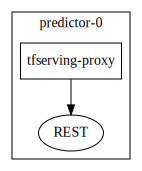

In [21]:
get_graph("tmp.json")

In [22]:
!pygmentize mnist.json

---
# Source: tfserving-mnist/templates/mnist_tfserving_deployment.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "tfserving-mnist",
	"namespace": "seldon"	
    },
    "spec": {
        "name": "tf-mnist",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/tfserving-proxy:0.1",
                                "name": "tfserving-proxy"
                            },
			    {
				"args": [
				    "/usr/bin/tensorflow_model_server",
				    "--port=8000",
				    "--model_name=mnist-model",
				    "--model_base_path=gs://seldon-tfserving-store/mnist-model"
				],
				"image": "gcr.io/kubeflow-images-public/tensorflow-serving-1.7:v20180604-0da89b8a",
				"name": "mnist-model",


**Port forward Ambassador**

```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080
```

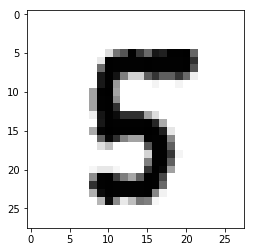

200
{
  "meta": {
    "puid": "faun2l1ftmp3r90cm6s5vnjo8a",
    "tags": {
    },
    "routing": {
    }
  },
  "data": {
    "names": ["t:0", "t:1", "t:2", "t:3", "t:4", "t:5", "t:6", "t:7", "t:8", "t:9"],
    "tensor": {
      "shape": [1, 10],
      "values": [1.124886839534156E-4, 9.059235132891086E-12, 0.0028196186758577824, 0.005111460108309984, 2.414313166809734E-5, 0.6415375471115112, 1.74979015810095E-6, 1.2785285052885342E-9, 0.34967318177223206, 7.198737002909184E-4]
    }
  }
}


In [24]:
data = gen_mnist_data(mnist)
data = data.reshape((784))
rest_request_ambassador("tfserving-mnist",endpoint="localhost:8003",arr=data)

## Analytics and Load Test

In [21]:
!helm install ../../../helm-charts/seldon-core-analytics --name seldon-core-analytics \
    --set grafana_prom_admin_password=password \
    --set persistence.enabled=false \
    --namespace seldon

NAME:   seldon-core-analytics
LAST DEPLOYED: Mon Sep 24 15:52:34 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/Service
NAME                      TYPE       CLUSTER-IP     EXTERNAL-IP  PORT(S)       AGE
alertmanager              ClusterIP  10.19.253.159  <none>       80/TCP        1s
grafana-prom              NodePort   10.19.251.82   <none>       80:30690/TCP  1s
prometheus-node-exporter  ClusterIP  None           <none>       9100/TCP      1s
prometheus-seldon         ClusterIP  10.19.245.167  <none>       80/TCP        1s

==> v1/Secret
NAME                 TYPE    DATA  AGE
grafana-prom-secret  Opaque  1     2s

==> v1/ServiceAccount
NAME        SECRETS  AGE
prometheus  1        2s

==> v1/Job
NAME                            DESIRED  SUCCESSFUL  AGE
grafana-prom-import-dashboards  1        0           1s

==> v1beta1/Deployment
NAME                     DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
alertmanager-deployment  1        1        1           0          1s
grafa

In [22]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node "gke-cluster-2-default-pool-54fbe785-wmcb" labeled


In [23]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace seldon \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://tf-mnist:8000 \
    --set oauth.enabled=false \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Mon Sep 24 15:52:43 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP     EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.19.255.204  <none>       5557:32342/TCP,5558:30493/TCP,8089:32034/TCP  0s

==> v1/Pod(related)
NAME                   READY  STATUS             RESTARTS  AGE
locust-slave-1-zncg4   0/1    ContainerCreating  0         0s
locust-master-1-9z8gm  0/1    ContainerCreating  0         0s




You should port-foward the grafana dashboard

```
kubectl port-forward $(kubectl get pods -n seldon -l app=grafana-prom-server -o jsonpath='{.items[0].metadata.name}') -n seldon 3000:3000
```

You can then view an analytics dashboard inside the cluster at http://localhost:3000/dashboard/db/prediction-analytics?refresh=5s&orgId=1. Your IP address may be different. get it via minikube ip. Login with:

    Username : admin

    password : password (as set when starting seldon-core-analytics above)